# Unzipping, splitting and preprocessing of the dataset

In [820]:
import os
import pandas as pd
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

In [821]:
# file fer2013.tar.gz must be in the same directory as the notebook
!tar -xf fer2013.tar.gz

In [822]:
# reading the data
os.chdir(os.getcwd() + '/fer2013')
full_data = pd.read_csv('fer2013.csv')
os.chdir('../')
print('Current directory: {} \n'.format(os.getcwd()))
full_data.head()

Current directory: C:\Users\Maksim Komatovskiy\Desktop\cv_proj 



,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [823]:
# here different helper functions are created

def str2array(string):
    img_array = np.array(string.split(' ')).astype(np.int64)
    return img_array

def create_subset_labeled_with(label,full_data):
    subdata = full_data[full_data['emotion'] == label]
    return subdata

def construct_a_batch(list_of_datasets,size_by_ten):
    batch = pd.DataFrame()
    
    for sub in list_of_datasets:
        idx = np.random.randint(0,len(sub),size_by_ten)
        subb = sub.iloc[idx]
        batch = pd.concat([batch,subb])
    return batch

from tqdm import tqdm

def create_F_matrix_from_subdataset(subdataset):
    F0 = subdataset['pixels'].iloc[0].reshape(-1,1)

    for i in tqdm(range(1, len(subdataset))):
        F0 = np.append(F0,subdataset['pixels'].iloc[i].reshape(-1,1),axis = 1)
        
    return F0

def mean_column(A):
    return A.mean(axis = 1)

def subtract_column_mean(A):
    column_mean = mean_column(A)
    return A - column_mean.reshape(-1,1)

def approximate_with_rank(A,r,return_decomposition = False):

    u,s,vh = np.linalg.svd(A,full_matrices = False) # decomposition
    #print(u.shape, s.shape,vh.shape)
    s = s[:r] #truncation
    u = u[:,:r]
    vh = vh[:r,:]
    #print(u.shape, s.shape,vh.shape)
    
    if return_decomposition:
        return u,s,vh
    else:
        A_ = np.dot(u,np.dot(np.diag(s),vh))
        return A_

def plot_eigf(U0,y):
    for i in range(y):
        f = U0[:,i]
        f = f.reshape(48,48)
        plt.figure(figsize = (8,8))
        plt.imshow(f,cmap = 'gray')
        plt.show()

In [824]:
# turn the data in the dataframes into the usable format

full_data['pixels'] = full_data['pixels'].apply(lambda x: str2array(x))

full_data['emotion'] = full_data['emotion'].apply(lambda x: np.int64(x))

In [825]:
# deleting the column usage, in our case it is quite useless

del full_data['Usage']

In [826]:
# Random train-test split

random.seed = 42

test_percentage = 0.1

test_indices = np.random.choice(range(0,len(full_data)),
                                      size = int(test_percentage*len(full_data)),
                                      replace = False)

test_set = full_data.iloc[test_indices]
full_data.drop(test_indices,inplace = True)


In [827]:
print(test_set.shape)
print(full_data.shape)

(3588, 2)
(32299, 2)


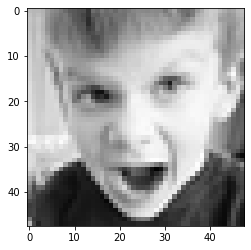

In [828]:
# Taking a glipse over how do the images look like

from matplotlib import pyplot as plt

img0 = full_data['pixels'].iloc[100].reshape(48,48)
plt.imshow(img0, cmap = 'gray');

In [829]:
### The ovarall idea of the pipeline

# We need to form some dataset with balanced classes, e.g. 100 random images from each category
# Then we build and approximation matrix F_norm, which can be induced by subtracting the mean and SVD truncation of the residual
# We project the test images on our singular vector space and therefore we find the closest from the prospect of the cosine similarity image to the test one
# We predict the label of the test image to be the same, as the label og the closest train one

# We stabilize the result by feeding e.g. 11 different subdatasets (one may call them batches) to our model and decide the total prediction by common majority vote


### NB f1_score would be used as the measure of quality in the end

In [830]:
# we try to work on the non-preprocessed, raw dataset for the moment

# we create subdatasets to work with eigenfaces

subdata_0 = create_subset_labeled_with(0,full_data)
subdata_1 = create_subset_labeled_with(1,full_data)
subdata_2 = create_subset_labeled_with(2,full_data)
subdata_3 = create_subset_labeled_with(3,full_data)
subdata_4 = create_subset_labeled_with(4,full_data)
subdata_5 = create_subset_labeled_with(5,full_data)
subdata_6 = create_subset_labeled_with(6,full_data)

In [831]:
list_of_datasets = [subdata_0,
                    subdata_1,
                    subdata_2,
                    subdata_3,
                    subdata_4,
                    subdata_5,
                    subdata_6]

In [832]:
# preparing the test data for quality check in the end

TEST_BATCH_SIZE = len(test_set)
testing_batch = construct_a_batch([test_set],TEST_BATCH_SIZE)
F_test = create_F_matrix_from_subdataset(testing_batch)

100%|██████████████████████████████████████████████████████████████████████████████| 3587/3587 [01:24<00:00, 42.54it/s]


In [935]:
################################
#HERE STARTS THE RUNNING OF A SINGLE MODEL
################################

In [977]:
PREDICTIONS = []

In [1014]:
for iters in range(3):

    # we construct a class - balanced subdataset

    TRAIN_BATCH_SIZE = 300
    batch = construct_a_batch(list_of_datasets,TRAIN_BATCH_SIZE)
    # sizes must be (7*second_arg,2)

    # we construct a matrix by columns (vectorized images of the test dataset)
    F0 = create_F_matrix_from_subdataset(batch)

    # we subtract the mean column to normalize it

    F0_norm = subtract_column_mean(F0)

    # we select the approximation strength (rank of truncation), which, obviously, should be less then min(F0.shape[0],F0.shape[1])

    R = 20


    # we build an R-rank approximation of the centralized F-matrix

    F0_norm_approx = approximate_with_rank(F0_norm, r = R)

    # we glimpse at the uniformness of approximation mistakes

    #plt.spy(F0_norm - F0_norm_approx,10); 

    # we decompose it again, but now keeping the factors

    U0,S0,Vh0 = approximate_with_rank(F0_norm, 
                                      r = R,
                                      return_decomposition=True)

    # we have a glimpse at the first columns of the U matrix, which form a basis in the space of faces (first several)
    # we wont need it in the last pipeline
    #plot_eigf(U0,3)

    # to make a projection of the correspondingly dimensioned vector on the subspace of eigenvectors, we need,
    # taking into account the properties of U matrix (unitary), to Compute U^t@vec = coefficients in the basis

    # jyst a debugging cell to check whether the model works on the only image

    test_img_vec = F_test



    print(F_test.shape)

    # now we need to project our test images on the subspace induced by singular vectors

    # we construct a projection matrix (U is unitary)

    # the shape would be R by len(vec(img)) = 2304

    projection_matrix = U0.T



    # performing the projection

    f2 = projection_matrix@test_img_vec

    # in general in is R by the TEST_BATCH_SIZE



    # the correspondency matrix, with which to compare (we search for the image with quite the same coefficients in linear combination)

    W = np.diag(S0)@Vh0


    dist = (cosine_similarity(f2.T, W.T).argmax(axis=1) + 1)



    prediction = batch['emotion'].iloc[dist]
    prediction = np.array(prediction)
    #print(prediction[:5])
    #print(prediction.shape)

    y_true = np.array(testing_batch['emotion'])

    f1_score(y_true,
             prediction,
             average='micro')
    
    PREDICTIONS.append(prediction)

  0%|                                                                                         | 0/2099 [00:00<?, ?it/s]

(2304, 3588)


  0%|                                                                                         | 0/2099 [00:00<?, ?it/s]

(2304, 3588)


100%|██████████████████████████████████████████████████████████████████████████████| 2099/2099 [00:28<00:00, 73.58it/s]


(2304, 3588)


In [1015]:
p = np.concatenate(PREDICTIONS[-3:])
p = p.reshape(-1,3588)

In [1016]:
p.shape

(3, 3588)

In [1017]:
p

array([[4, 5, 5, ..., 2, 4, 2],
       [0, 1, 5, ..., 4, 5, 5],
       [3, 5, 6, ..., 2, 6, 6]], dtype=int64)

In [1018]:
all_pred = np.int64(np.median(p,axis = 0))

In [1019]:
f1_score(all_pred,y_true,average='micro')

0.16025641025641027

In [1020]:
y_true

array([5, 2, 3, ..., 3, 4, 3], dtype=int64)